In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import re
import json
import copy

import nltk
from nltk.stem import WordNetLemmatizer
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from tqdm import tqdm

In [14]:
from transformers import pipeline

In [15]:
import spacy

# Load nlp model
nlp = spacy.load('en_core_web_sm')

# Load Data

In [16]:
with open("temp/meta-data.json", "r") as file:
    data = json.load(file)

print(len(data))

1511


In [17]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         1511 non-null   int64 
 1   review_time       1511 non-null   object
 2   like              1511 non-null   int64 
 3   review            1511 non-null   object
 4   review_processed  1511 non-null   object
 5   aspect_sentiment  1511 non-null   object
dtypes: int64(2), object(4)
memory usage: 82.6+ KB
None


,review_id,review_time,like,review,review_processed,aspect_sentiment
0,0,2024-11-28,0,The cars design is like it came from a cartoon.,The cars design is like it came from a cartoon.,"[{'term': 'cars design', 'class': 'negative', ..."
1,2,2024-11-27,0,Tankz u for being so honest.\nMuch love and re...,Tankz u for being so honest.\nMuch love and re...,"[{'term': 'much love', 'class': 'positive', 'p..."
2,3,2024-11-26,0,Amazing review your really good at this love w...,Amazing review your really good at this love w...,"[{'term': 'well', 'class': 'positive', 'probab..."
3,5,2024-11-25,0,"Honestly, the Cybertruck might be the first ca...",The Cybertruck might be the first car I've eve...,"[{'term': 'first car', 'class': 'negative', 'p..."
4,6,2024-11-25,0,I will be buying one anytime soon add expensiv...,I will be buying one anytime soon. It's a very...,"[{'term': 'stuff', 'class': 'positive', 'proba..."


# Aspect Classification

In [18]:
aspects = {}
text = ""
for items in df['aspect_sentiment'].values:
    for item in items:
        term = item.get('term')
        text = text + term + " " 
        if term not in aspects.keys():
            aspects[term] = 1
        else:
            aspects[term] = aspects[term] + 1
print(len(aspects))

3120


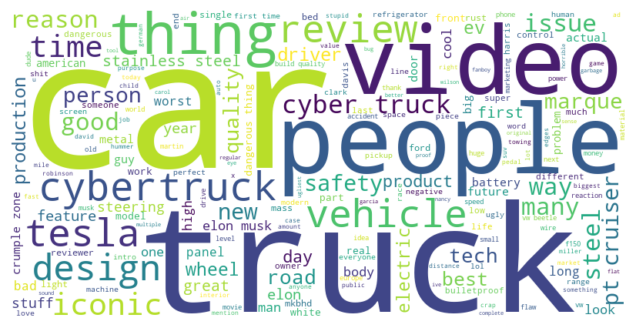

In [19]:
from wordcloud import WordCloud


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
with open('temp/aspects.json', 'w', encoding='utf-8') as f:
    json.dump(list(aspects.keys()), f, indent=4)


In [21]:
with open('temp/topic-classification.json', 'r', encoding='utf-8') as f:
    classification = json.load(f)

In [22]:
def get_key(dictionary, value):
    for k, v in dictionary.items():
        if value in v:
            return k
    return
            
def generate_topics(dictionary):
    return list(dictionary.keys())

In [23]:
# Save topic-aspect dataframe

# Padding dictionary
def padding(dict_: dict):
    result = {}
    target_length = max([len(x) for x in dict_.values()])
    for k, v in dict_.items():
        result[k] = v + [np.nan] * (target_length - len(v))
    return result


padded_aspects = padding(classification)

df_topic_aspect = pd.DataFrame.from_dict(padded_aspects)

df_topic_aspect.head()

,Automotive Terms,Features and Components,Performance Metrics,Design and Aesthetics,Safety and Reliability,Miscellaneous
0,cars,drive,acceleration,exterior,safety,garage
1,tank,body,speed,interior,driver safety,music
2,truck,dashboard,weight,design,pedestrian safety,weight
3,toyota,screen,performance section,aesthetics,crash test,congestion
4,lotus elise,wheels,towing power,styling,reliability,roads


In [24]:
# Save to excel

df_topic_aspect.to_excel("table/topic-aspect.xlsx", index=False)

# Table Main

In [25]:
df.head()

,review_id,review_time,like,review,review_processed,aspect_sentiment
0,0,2024-11-28,0,The cars design is like it came from a cartoon.,The cars design is like it came from a cartoon.,"[{'term': 'cars design', 'class': 'negative', ..."
1,2,2024-11-27,0,Tankz u for being so honest.\nMuch love and re...,Tankz u for being so honest.\nMuch love and re...,"[{'term': 'much love', 'class': 'positive', 'p..."
2,3,2024-11-26,0,Amazing review your really good at this love w...,Amazing review your really good at this love w...,"[{'term': 'well', 'class': 'positive', 'probab..."
3,5,2024-11-25,0,"Honestly, the Cybertruck might be the first ca...",The Cybertruck might be the first car I've eve...,"[{'term': 'first car', 'class': 'negative', 'p..."
4,6,2024-11-25,0,I will be buying one anytime soon add expensiv...,I will be buying one anytime soon. It's a very...,"[{'term': 'stuff', 'class': 'positive', 'proba..."


In [26]:
topic_json = {k: 0 for k in list(classification.keys())}
topic_json

{'Automotive Terms': 0,
 'Features and Components': 0,
 'Performance Metrics': 0,
 'Design and Aesthetics': 0,
 'Safety and Reliability': 0,
 'Miscellaneous': 0}

**Topic Classification**

In [29]:
# Topic records

records = []
for _, row in df.iterrows():
    record = {'review_id': row['review_id']}
    items = row['aspect_sentiment']
    record.update(topic_json.copy())
    for item in items:
        term = item['term']
        topic = get_key(classification, term)
        if topic:
            record[topic] = 1
    records.append(record)

records[:5]

[{'review_id': 0,
  'Automotive Terms': 0,
  'Features and Components': 0,
  'Performance Metrics': 0,
  'Design and Aesthetics': 0,
  'Safety and Reliability': 0,
  'Miscellaneous': 0},
 {'review_id': 2,
  'Automotive Terms': 0,
  'Features and Components': 0,
  'Performance Metrics': 0,
  'Design and Aesthetics': 0,
  'Safety and Reliability': 0,
  'Miscellaneous': 0},
 {'review_id': 3,
  'Automotive Terms': 0,
  'Features and Components': 0,
  'Performance Metrics': 0,
  'Design and Aesthetics': 0,
  'Safety and Reliability': 0,
  'Miscellaneous': 0},
 {'review_id': 5,
  'Automotive Terms': 0,
  'Features and Components': 0,
  'Performance Metrics': 0,
  'Design and Aesthetics': 0,
  'Safety and Reliability': 0,
  'Miscellaneous': 0},
 {'review_id': 6,
  'Automotive Terms': 0,
  'Features and Components': 0,
  'Performance Metrics': 0,
  'Design and Aesthetics': 0,
  'Safety and Reliability': 0,
  'Miscellaneous': 0}]

**Save Table per Topic**

In [30]:
topic_df = pd.DataFrame.from_dict(records)

topic_df.head()

,review_id,Automotive Terms,Features and Components,Performance Metrics,Design and Aesthetics,Safety and Reliability,Miscellaneous
0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,5,0,0,0,0,0,0
4,6,0,0,0,0,0,0


In [31]:
def formatting_aspect(items):
    format = ""
    for i, item in enumerate(items):
        term = item.get('term')
        sentiment = item.get('class')
        if get_key(classification, term):
            format += f"● {term}: {sentiment}"
            if i != len(items) - 1:
                format += "\n"
    return format

def generate_table(df: pd.DataFrame, topic_df: pd.DataFrame, topic: str):
    drop = ['review_processed']
    mask = topic_df[topic_df[topic] == 1]['review_id'].values
    result = df[df['review_id'].isin(mask)].copy()
    result['aspect_sentiment'] = result['aspect_sentiment'].apply(formatting_aspect)
    result['topic'] = [topic] * result.shape[0]
    result = result.drop(drop, axis=1).sort_values(by='review_time').reset_index(drop=True)

    return result

In [32]:
topics = generate_topics(classification)

frames = []
for topic in topics:
    temp = generate_table(df, topic_df, topic)
    frames.append(temp)
    # Save to excel
    # temp.to_excel(f"table/main_mcd_{topic}.xlsx", index=False)

In [37]:
df_main = pd.concat(frames).sort_values(by='review_time')

print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 0 to 69
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         165 non-null    int64 
 1   review_time       165 non-null    object
 2   like              165 non-null    int64 
 3   review            165 non-null    object
 4   aspect_sentiment  165 non-null    object
 5   topic             165 non-null    object
dtypes: int64(2), object(4)
memory usage: 9.0+ KB
None


,review_id,review_time,like,review,aspect_sentiment,topic
0,2768,2024-04-01,1,Will you ever speak to the fact that Tesla is ...,● tesla: negative,Automotive Terms
2,2531,2024-04-01,1,I would never buy a car where the steer wheel ...,● steering wheel: negative\n,Features and Components
3,2707,2024-04-01,0,Off Topic question... What aspect ratio are yo...,● aspect ratio: positive,Design and Aesthetics
1,2549,2024-04-01,1,"This Review is on a complete different level, ...",● air suspension: negative\n,Features and Components
0,2565,2024-04-01,4,7:31 Just because the car will be intact doesn...,● crumple zones: negative\n,Features and Components


In [36]:
df_main[df_main['review_id'] == 0]

,review_id,review_time,like,review,aspect_sentiment,topic


In [38]:
# Save to excel
df_main.to_excel("table/main.xlsx", index=False)

# Table Aspects

In [39]:
df.head()

,review_id,review_time,like,review,review_processed,aspect_sentiment
0,0,2024-11-28,0,The cars design is like it came from a cartoon.,The cars design is like it came from a cartoon.,"[{'term': 'cars', 'class': 'negative', 'probab..."
1,2,2024-11-27,0,Tankz u for being so honest.\nMuch love and re...,Tankz u for being so honest.\nMuch love and re...,"[{'term': 'tank', 'class': 'positive', 'probab..."
2,3,2024-11-26,0,Amazing review your really good at this love w...,Amazing review your really good at this love w...,[]
3,5,2024-11-25,0,"Honestly, the Cybertruck might be the first ca...",The Cybertruck might be the first car I've eve...,"[{'term': 'stick', 'class': 'negative', 'proba..."
4,6,2024-11-25,0,I will be buying one anytime soon add expensiv...,I will be buying one anytime soon. It's a very...,"[{'term': 'truck', 'class': 'negative', 'proba..."


In [45]:
# Output: id, date, aspect, sentiment, topic
def recording_aspect(row):
    records = []
    id_ = row['review_id']
    date_ = row['review_time']
    items = row['aspect_sentiment']
    like = row['like']
    
    for item in items:
        aspect = item.get('term')
        aspect = nlp(aspect)[0:].lemma_
        sentiment = item.get('class')
        topic = get_key(classification, aspect)
        records.append({'review_id': id_, 'review_time': date_, 'aspect':aspect, 'sentiment': sentiment, 'topic': topic, 'like': like})
    return records

In [46]:
records = []

for _, row in df.iterrows():
    records += recording_aspect(row)

records[:5]

[{'review_id': 0,
  'review_time': '2024-11-28',
  'aspect': 'car',
  'sentiment': 'negative',
  'topic': 'Automotive Terms',
  'like': 0},
 {'review_id': 2,
  'review_time': '2024-11-27',
  'aspect': 'tank',
  'sentiment': 'positive',
  'topic': 'Miscellaneous',
  'like': 0},
 {'review_id': 5,
  'review_time': '2024-11-25',
  'aspect': 'stick',
  'sentiment': 'negative',
  'topic': 'Miscellaneous',
  'like': 0},
 {'review_id': 6,
  'review_time': '2024-11-25',
  'aspect': 'truck',
  'sentiment': 'negative',
  'topic': 'Automotive Terms',
  'like': 0},
 {'review_id': 13,
  'review_time': '2024-11-19',
  'aspect': 'toyota',
  'sentiment': 'neutral',
  'topic': 'Automotive Terms',
  'like': 0},
 {'review_id': 13,
  'review_time': '2024-11-19',
  'aspect': 'drive',
  'sentiment': 'neutral',
  'topic': 'Miscellaneous',
  'like': 0},
 {'review_id': 15,
  'review_time': '2024-11-16',
  'aspect': 'body',
  'sentiment': 'negative',
  'topic': 'Miscellaneous',
  'like': 0},
 {'review_id': 15,
 

In [47]:
df_record = pd.DataFrame.from_dict(records)

# Create pivot table
df_aspect = (
    df_record.groupby(["aspect", "review_time", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_aspect['total'] = df_aspect['negative'] + df_aspect['positive'] + df_aspect['neutral']

# Fix datetime
# Convert review_time to datetime
df_aspect['review_time'] = pd.to_datetime(df_aspect['review_time'])

# Extract year and month
df_aspect['month'] = df_aspect['review_time'].apply(lambda x: x.replace(day=1).date())
df_aspect['year'] = df_aspect['review_time'].apply(lambda x: x.replace(day=1, month=1).date())
df_aspect['review_time'] = df_aspect['review_time'].apply(lambda x: x.date())

df_aspect = df_aspect.rename_axis(index=None, columns=None)

# Identify categorical and date columns
categorical_date_columns = ['aspect', 'review_time', 'year', 'month']

# Identify numeric columns
numeric_columns = [col for col in df_aspect.columns if col not in categorical_date_columns]

df_aspect = df_aspect[categorical_date_columns + numeric_columns]

df_aspect.head()

,aspect,review_time,year,month,negative,neutral,positive,total
0,""" steel",2024-04-01,2024-01-01,2024-04-01,1,0,0,1
1,sell,2024-04-01,2024-01-01,2024-04-01,0,0,1,1
2,color,2024-04-01,2024-01-01,2024-04-01,0,0,1,1
3,scroll wheel,2024-04-01,2024-01-01,2024-04-01,1,0,0,1
4,screen,2024-04-01,2024-01-01,2024-04-01,1,0,0,1
...,...,...,...,...,...,...,...,...
1630,toyota,2024-11-19,2024-01-01,2024-11-01,0,1,0,1
1631,truck,2024-11-25,2024-01-01,2024-11-01,1,0,0,1
1632,stick,2024-11-25,2024-01-01,2024-11-01,1,0,0,1
1633,tank,2024-11-27,2024-01-01,2024-11-01,0,0,1,1


**Save Table per Aspect**

In [77]:
df_aspect.to_excel("table/aspect.xlsx", index=False)

**Mapping Topic-Aspect**

In [49]:
df_aspect['topic'] = df_aspect['aspect'].apply(lambda x: get_key(classification, x))

df_aspect.head()

,aspect,review_time,year,month,negative,neutral,positive,total,topic
0,""" steel",2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous
1,sell,2024-04-01,2024-01-01,2024-04-01,0,0,1,1,Miscellaneous
2,color,2024-04-01,2024-01-01,2024-04-01,0,0,1,1,Design and Aesthetics
3,scroll wheel,2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous
4,screen,2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous


# Table Trend

In [50]:
df_record.head()

,review_id,review_time,aspect,sentiment,topic,like
0,0,2024-11-28,car,negative,Automotive Terms,0
1,2,2024-11-27,tank,positive,Miscellaneous,0
2,5,2024-11-25,stick,negative,Miscellaneous,0
3,6,2024-11-25,truck,negative,Automotive Terms,0
4,13,2024-11-19,toyota,neutral,Automotive Terms,0


In [53]:
# Create trend dataframe

temp_1 = ( df_record.groupby(["topic", "review_time"])
    .agg({'like': ['sum', 'count']})
    .sort_values(by='review_time')
).reset_index()

temp_1.columns = ['_'.join(col).strip() if len(col[-1]) > 0 else col[0] for col in temp_1.columns.values]

temp_2 = (
    df_record.groupby(["topic", "review_time", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_trend = temp_1.merge(temp_2, on=['topic', 'review_time'])
df_trend['total'] = df_trend['negative'] + df_trend['positive'] + df_trend['neutral']

df_trend.head()

,topic,review_time,like_sum,like_count,negative,neutral,positive,total
0,Automotive Terms,2024-04-01,100,13,5,1,7,13
1,Miscellaneous,2024-04-01,493,164,99,17,48,164
2,Features and Components,2024-04-01,1,1,1,0,0,1
3,Design and Aesthetics,2024-04-01,0,3,0,0,3,3
4,Performance Metrics,2024-04-01,0,3,1,0,2,3


In [54]:
# Fix datetime
# Convert review_time to datetime
df_trend['review_time'] = pd.to_datetime(df_trend['review_time'])

# Extract year and month
df_trend['month'] = df_trend['review_time'].apply(lambda x: x.replace(day=1).date())
df_trend['year'] = df_trend['review_time'].apply(lambda x: x.replace(day=1, month=1).date())
df_trend['review_time'] = df_trend['review_time'].apply(lambda x: x.date())

# Identify categorical and date columns
categorical_date_columns = ['topic', 'review_time', 'year', 'month']

# Identify numeric columns
numeric_columns = [col for col in df_trend.columns if col not in categorical_date_columns]


df_trend = df_trend[categorical_date_columns + numeric_columns]

df_trend.head()

,topic,review_time,year,month,like_sum,like_count,negative,neutral,positive,total
0,Automotive Terms,2024-04-01,2024-01-01,2024-04-01,100,13,5,1,7,13
1,Miscellaneous,2024-04-01,2024-01-01,2024-04-01,493,164,99,17,48,164
2,Features and Components,2024-04-01,2024-01-01,2024-04-01,1,1,1,0,0,1
3,Design and Aesthetics,2024-04-01,2024-01-01,2024-04-01,0,3,0,0,3,3
4,Performance Metrics,2024-04-01,2024-01-01,2024-04-01,0,3,1,0,2,3


**Save Table Trend**

In [55]:
df_trend.to_excel("table/trend.xlsx", index=False)

# Prepare Table for SWOT Analysis

In [56]:
swot_json = {k: f"Descriptive sentiment summary with bullet point format only about {k}:\n\n" for k in list(classification.keys())}
swot_json

{'Automotive Terms': 'Descriptive sentiment summary with bullet point format only about Automotive Terms:\n\n',
 'Features and Components': 'Descriptive sentiment summary with bullet point format only about Features and Components:\n\n',
 'Performance Metrics': 'Descriptive sentiment summary with bullet point format only about Performance Metrics:\n\n',
 'Design and Aesthetics': 'Descriptive sentiment summary with bullet point format only about Design and Aesthetics:\n\n',
 'Miscellaneous': 'Descriptive sentiment summary with bullet point format only about Miscellaneous:\n\n'}

In [57]:
for items in df['aspect_sentiment'].values:
    for item in items:
        if len(item) == 0:
            continue
        term = item.get('term')
        context = item.get('context')
        if len(context) > 0:
            context = context[0]
            class_ = get_key(classification, term)
            if context not in swot_json[class_]:
                swot_json[class_] = swot_json[class_] + "- " + context + "\n"

df_context_topic = pd.DataFrame.from_dict(swot_json, 'index', columns=['context']).T
df_context_topic

,Automotive Terms,Features and Components,Performance Metrics,Design and Aesthetics,Miscellaneous
context,Descriptive sentiment summary with bullet poin...,Descriptive sentiment summary with bullet poin...,Descriptive sentiment summary with bullet poin...,Descriptive sentiment summary with bullet poin...,Descriptive sentiment summary with bullet poin...


In [58]:
df_context_topic.to_excel("table/context_table.xlsx", index=False)

PROMPT SUMMARIZE FORMAT:

Descriptive sentiment summary with bullet point format only about "topic": <text>

# Exploratory Data Analysis

**Table Trend**

In [59]:
# Distribution review

df_trend.head()

,topic,review_time,year,month,like_sum,like_count,negative,neutral,positive,total
0,Automotive Terms,2024-04-01,2024-01-01,2024-04-01,100,13,5,1,7,13
1,Miscellaneous,2024-04-01,2024-01-01,2024-04-01,493,164,99,17,48,164
2,Features and Components,2024-04-01,2024-01-01,2024-04-01,1,1,1,0,0,1
3,Design and Aesthetics,2024-04-01,2024-01-01,2024-04-01,0,3,0,0,3,3
4,Performance Metrics,2024-04-01,2024-01-01,2024-04-01,0,3,1,0,2,3


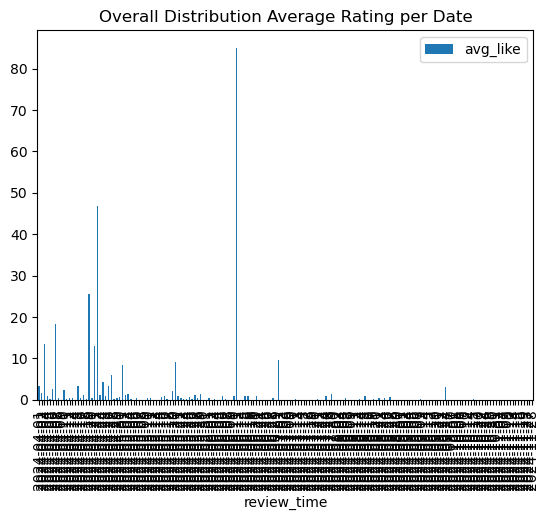

In [64]:
temp = df_trend.groupby('review_time').agg({'like_sum': 'sum', 'like_count': 'sum'})
temp['avg_like'] = (temp['like_sum'] / temp['like_count']).fillna(0)

temp.drop(['like_sum', 'like_count'], axis=1).plot(kind='bar', title="Overall Distribution Average Rating per Date")
plt.show()

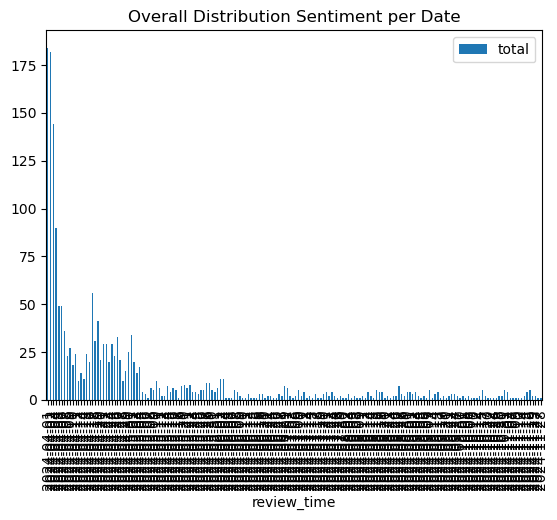

In [65]:
df_trend.groupby('review_time').agg({'total':'sum'}).plot(kind='bar', title="Overall Distribution Sentiment per Date")
plt.show()

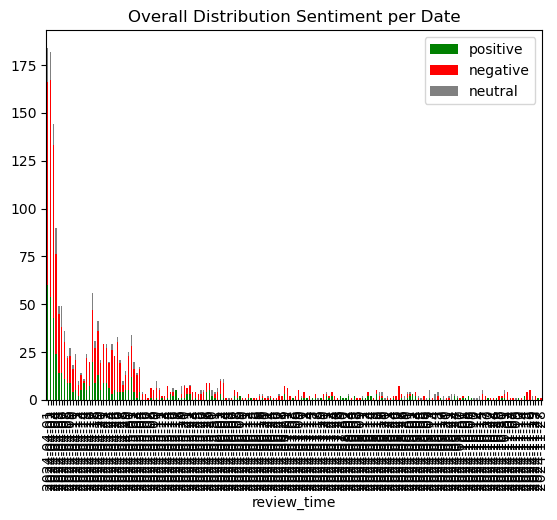

In [66]:
df_trend\
    .groupby('review_time')\
    .agg({'positive':'sum', 
          'negative':'sum',
          'neutral': 'sum'})\
    .plot(kind='bar', 
          title="Overall Distribution Sentiment per Date",
          stacked=True, 
          color=['green', 'red', 'gray'])

plt.show()

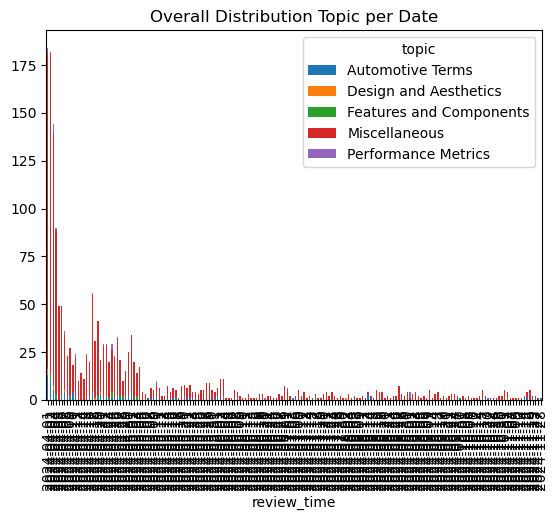

In [67]:
df_trend\
    .groupby(['review_time', 'topic'])\
    .agg({'total': 'sum'})\
    .rename({'total': 'count'}, axis=1)\
    .reset_index()\
    .pivot(index='review_time', columns='topic', values='count')\
    .fillna(0)\
    .plot(kind='bar', stacked=True, title='Overall Distribution Topic per Date')

plt.show()

**Table Aspect**

In [68]:
topics = generate_topics(classification)

print(topics)

['Automotive Terms', 'Features and Components', 'Performance Metrics', 'Design and Aesthetics', 'Miscellaneous']


In [69]:
# VARIABLES
FROM_DATE = "2019-12-01"
TO_DATE = "2024-01-01"
TOPIC = "Food and Menu Items"

MIN_DATE = np.min(df_trend['review_time'])
FROM_DATE = pd.to_datetime(MIN_DATE).date() if len(FROM_DATE) == 0 else pd.to_datetime(FROM_DATE).date()


MAX_DATE = np.max(df_trend['review_time'])
TO_DATE = pd.to_datetime(MIN_DATE).date() if len(TO_DATE) == 0 else pd.to_datetime(TO_DATE).date()

In [70]:
df_aspect['review_time'] = df_aspect['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_aspect.head()

,aspect,review_time,year,month,negative,neutral,positive,total,topic
0,""" steel",2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous
1,sell,2024-04-01,2024-01-01,2024-04-01,0,0,1,1,Miscellaneous
2,color,2024-04-01,2024-01-01,2024-04-01,0,0,1,1,Design and Aesthetics
3,scroll wheel,2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous
4,screen,2024-04-01,2024-01-01,2024-04-01,1,0,0,1,Miscellaneous


In [72]:
# Distribution per aspect

mask = (df_aspect['review_time'] >= FROM_DATE) & (df_aspect['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_aspect[mask].copy()
if len(temp) > 0:
    if TOPIC:
        mask = (temp['topic'] == TOPIC)
        temp = temp[mask].copy()
    temp = temp.drop(['review_time', 'year', 'month', 'topic'], axis=1).groupby(['aspect']).sum().sort_values(by='total', ascending=True)
    
    temp\
        .drop(['total'], axis=1)\
        .plot(kind='barh',
              stacked=True,
              color=['red', 'gray', 'green'])
    
    plt.show()
else:
    print("EMPTY FRAME")

FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01
EMPTY FRAME


**Table Main**

In [73]:
df_main['review_time'] = df_main['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_main.head()

,review_id,review_time,like,review,aspect_sentiment,topic
0,2763,2024-04-01,0,Day 3 of rewatching this video\nAnd trying to ...,● truck: negative,Automotive Terms
25,2557,2024-04-01,0,This was such a lovely video and review. The h...,● video: positive,Miscellaneous
26,2552,2024-04-01,4,They pose a significant threat to basically an...,● mass: negative\n● frame: negative,Miscellaneous
27,2551,2024-04-01,1,Seeing Marques make excuses for the Cybertruck...,● mar: negative,Miscellaneous
28,2473,2024-04-01,0,I don't believe this is independant journalism...,● door: negative\n● tesla: negative,Miscellaneous


In [76]:
pd.set_option('display.max_colwidth', 2000)

mask = (df_main['review_time'] >= FROM_DATE) & (df_main['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_main[mask].copy()

if TOPIC:
    mask = (temp['topic'] == TOPIC)
    temp = temp[mask].copy()

# if ASPECT:
    # mask = (temp['aspect'])

temp = temp[['review', 'aspect_sentiment', 'like']].sort_values(by='like', ascending=False)
temp

FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01


,review,aspect_sentiment,like
